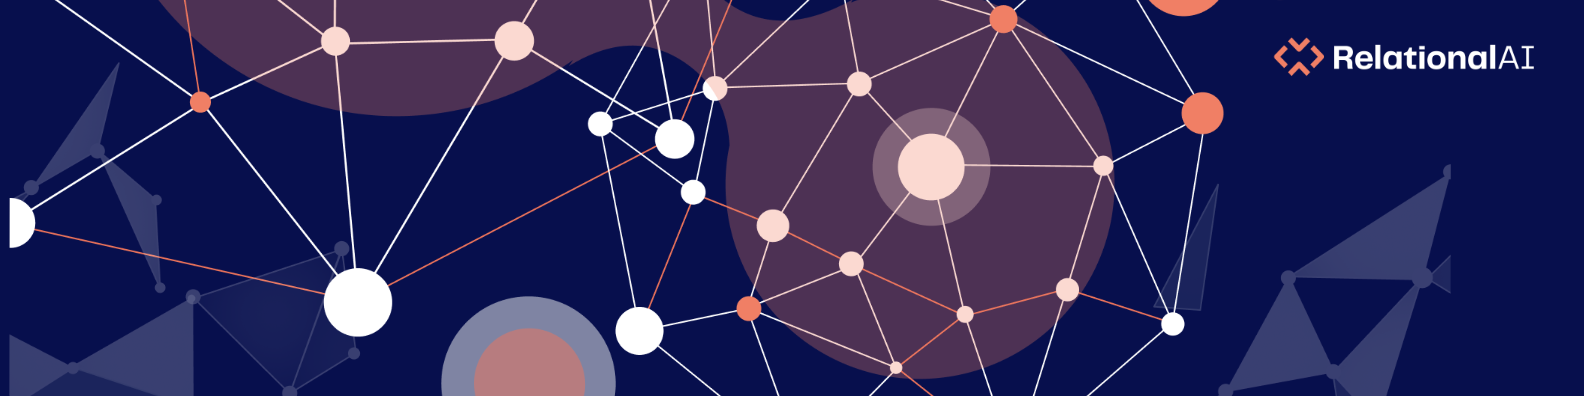


# Entity Resolution 

## Overview

Entity resolution is a common challenge when it comes to data integration and cleansing. Its goal is to accurately identify and connect records that correspond to the same real-world entity.

Imagine you have a dataset of people and their occupations and another dataset of people and their home phone numbers. In the first dataset, there is a person named "John Smith", in the second dataset there is a person named "John Smyth". Is this just a typo? Does this refer to the same person? Or are these two different people? Entity resolution is the process of identifying and merging records that refer to the same real-world entity. It involves detecting duplicates and consolidating them to ensure that each entity is represented only once in the dataset.

In this notebook, we will go through an example of entity resolution, specifically focusing on identity resolution, using deterministic rule-based matching techniques. This problem is sometimes solved using Machine Learning-based techniques, which we don't include in this demo. 
We will work with instances of users described by attributes such as name, date of birth, email, etc. We will explore how to match and merge records to identify unique individuals.
***

## Let's get started!

### Importing Packages 
We start by installing and importing all the Python packages and modules that we will need, including the `relationalai` package. We then define the `EntityResolution` model object. 

In [ ]:
%pip install relationalai matplotlib

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std import alias, rel, strings
from relationalai.std import aggregates
from typing import Tuple
import matplotlib as mpl
import pandas as pd

provider = rai.Provider()

In [ ]:
provider.sql("""
begin
	create database if not exists RAI_DEMO;
	create schema if not exists RAI_DEMO.IDENTITY_RESOLUTION;

	create or replace table RAI_DEMO.IDENTITY_RESOLUTION.USERS (
		ID NUMBER(18,0),
		NAME VARCHAR(16777216),
		DATE_OF_BIRTH VARCHAR(16777216),
		EMAIL VARCHAR(16777216),
		PHONE_NUMBER VARCHAR(16777216),
		CREDIT_CARD_NUMBER VARCHAR(16777216)
	);

	insert into RAI_DEMO.IDENTITY_RESOLUTION.USERS (ID, NAME, DATE_OF_BIRTH, EMAIL, PHONE_NUMBER, CREDIT_CARD_NUMBER)
	values
	(1,'John Smith','1990-05-15','john.smith@example.com','+1234567890','1234 5678 9012 3456'),
	(2,'John Smyth','1990-05-16','john.smyth@example.com','+1234567809','1234 5678 9012 3456'),
	(3,'Jane Doe','1985-10-20','jane.doe@example.com','+1987654321','2345 6789 0123 4567'),
	(4,'Michael Johnson','1982-07-08','michael.johnson@example.com','+1654321879','3456 7890 1234 5678'),
	(5,'Michael Jackson','1982-07-08','michael.jackson@example.com','+1654321879','3456 7890 1234 5678'),
	(6,'John Smith','1990-05-15','john.smith@example.com','+1234567890','1234 5678 9012 3456');
end;
""")

In [ ]:
provider.create_streams(["RAI_DEMO.IDENTITY_RESOLUTION.USERS"], "EntityResolution")


In [ ]:

model = rai.Model("EntityResolution", ensure_change_tracking=True)

> **Note**. Models represent collections of objects. Objects, like Python objects, have types and properties, which we will define in a bit.

### Importing the Data from Snowflake
We now can import data from the Snowflake table that contains details we have of our users.

> **Note**. We access data in Snowflake by simply passing our table location as `source` parameter while creating a model type in the format `<my_database.my_schema.my_table>`. `User` now contains the data from a database called `rai_demo`, schema `identity_resolution` and table `users`. 

In [3]:
User = model.Type("User", source = "rai_demo.identity_resolution.users")

> **Note**. We connect to Snowflake and create a Snowpark session using the `rai init` command. A `data stream` between the `users` table and the `EntityResolution` model was created to stream the data from Snowflake to the RAI schema. 

## Getting to know the raw input data

Let's query our user data to confirm everything is setup properly and to understand the inputs.

First, we check what are all the properties our `User` objects have using `User.known_properties()`.

In [4]:
User.known_properties()

['snowflake_id',
 'email',
 'credit_card_number',
 'date_of_birth',
 'name',
 'id',
 'phone_number']

> **Note**. The `snowflake_id` property is the RAI internal identifier of a row in a Snowflake table and can be ignored.

Now we can query all these properties and take a look at their values.

In [5]:
with model.query() as select:
    u = User()
    response = select(u.id, u.name, u.email, u.date_of_birth, u.phone_number, u.credit_card_number)

response

> **Tip**. Looking at the data, we can see user records that are very likely to be duplicates based on some attributes. For example, it’s very likely that users with ids 4 and 5 correspond to the same underlying entity. But how can we accurately identify them? And how confident can we be that they are truly duplicates? To address this, we need to establish some specific rules.

## Approaches for matching entities
There are many different ways to identify if two users correspond to the same entity. In the following sections, we're going to focus on the following methods:
1. *Exact Match*: in this approach, in order for two users to correspond to the same entity we require all their attributes aside from `id` to have exactly matching values.

2. *Weighted Attribute Match*: the above method is too strict as even one small typo prevents the detection of a match. To address this, the second method assigns weights to attributes and calculates a weighted average similarity score normalized between 0 and 1. To make a decision we set a threshold value and if the score is above this threshold then we conclude that the two entries correspond to the same entity.

3. *Fuzzy Attribute Match*: on top of the weighted attribute match, this approach looks closer at string values of user attributes to identify how similar they are before making a decision. For example, the pair "John Smith" and "John Smyth" is more similar compared to the pair "John Smith" and "Michael Jackson".

In the end we will summarize the results of these three approaches to make a final conclusion. So let's start with the first one.

## Exact Match
First, let's define a rule to only match records that are an exact match, where all attributes between two users are identical. If that's the case we consider them matching completely.
We create a new type `ExactMatch` to represent each such pair of users.

In [6]:
ExactMatch = model.Type("ExactMatch")

exact_match_attributes = ['name', 'date_of_birth', 'email', 'phone_number', 'credit_card_number']

with model.rule(dynamic=True):
    user1 = User()
    user2 = User()
    user1 < user2
    for attribute in exact_match_attributes:
        getattr(user1, attribute) == getattr(user2, attribute)
    ExactMatch.add(user1=user1, user2=user2)

> **Note**. In the rule above, we compare `user1` and `user2` to make sure that we only create a new object for each pair of users once, and that we don't compare users with themselves.

Let's see if we found any exact matches in our dataset.

In [7]:
with model.query() as select:
    em = ExactMatch()
    response = select(*[attr for pair in ([alias(getattr(em.user1, a), a + " (1)"), alias(getattr(em.user2, a), a + " (2)")] for a in exact_match_attributes) for attr in pair])

response

### Visualizing Graph
Let's also visualize a graph where nodes represent all the users and an edge between two nodes represents a user match we've identified.

In [ ]:
exact_match_graph = Graph(model, undirected=True)
Node, Edge = exact_match_graph.Node, exact_match_graph.Edge

Node.extend(User, label=User.name, id=User.id)

with model.rule():
    exact_match = ExactMatch()
    Edge.add(exact_match.user1, exact_match.user2)

graph_style = {
    "node": {
        "color": "slategray",
        "hover": lambda n: f"Id: {n['id']}"
    },
    "edge": {
        "color": "coral",
        "size": lambda e: e.get('weight', 1.0) * 3,
        "hover": lambda e: f"Weight: {e.get('weight', 1.0):.2f}"
    }
}

exact_match_graph.visualize(style = graph_style).display(inline=True)

## Matching based on weighted attributes
Let's try a second method, where we still only consider attributes to match if their values are exactly the same, but we add weights to them, corresponding to how important the attributes are in identifying a user.

We first choose and assign the weights to the attributes we have.
> **Note**. Here it's sufficient to do this manually based on intuition and domain knowledge, while in the machine learning world the weights are learned from the data.

We also create a new type `ExactAttributeMatch`. In a rule, if an attribute matches between two users, we add it and associate the weight of the attribute with that match. We then normalize the total score between every two users to get the similarity score between 0 and 1.

In [9]:
attribute_weights = {
    'name': 0.2, # Lower weight due to commonality and potential for variations or typos
    'email': 0.5, # Moderate weight as email is unique but can be changed or have multiple versions
    'credit_card_number': 0.85, # High weight since credit card numbers are unique and less likely to be shared
    'phone_number': 0.9 # Highest weight as phone numbers are highly unique and rarely shared among different users
}

ExactAttributeMatch = model.Type("ExactAttributeMatch")

with model.rule(dynamic=True):
    user1 = User()
    user2 = User()
    user1 < user2
    for (attribute, weight) in attribute_weights.items():
        with getattr(user1, attribute) == getattr(user2, attribute):
            ExactAttributeMatch.add(user1=user1, user2=user2, attribute=attribute).set(weight=weight)

# Aggregate the scores considering the weights of all the exact attribute matches
with model.rule():
    match = ExactAttributeMatch()
    norm_score = aggregates.sum(match.weight, per=[match.user1, match.user2]) / sum(attribute_weights.values())
    ExactAttributeMatch.add(user1=match.user1, user2=match.user2).set(combined_similarity_score=norm_score)

We can now run a query to get the aggregated similarity score for each new match.

In [10]:
with model.query() as select:
    e = ExactAttributeMatch()
    e.combined_similarity_score.has_value()
    result = select(alias(e.user1.id, "id (user1)"), alias(e.user1.name, "name (user1)"), alias(e.user2.id, "id (user2)"), alias(e.user2.name, "name (user2)"), alias(e.combined_similarity_score, "combined similarity score"))
result

> **Tip**. We can see our users with ids 1 and 6 identified using the first approach expectedly get a 1.0 (100%) similarity score. Another high-scoring pair is users with ids 4 and 5, which we noticed before, but is lower since, as we see, the names don't match exactly.

Let's set a threshold of `0.7` to ensure a good balance between matching accuracy and avoiding false matches.

### Visualizing Graph
Next step is to visualize the graph where an edge between two nodes represents the normalized similarity between two users. We only consider the edges with a score greater than the chosen threshold of `0.7`.

In [11]:
exact_attribute_match = Graph(model, undirected=True, weighted=True)
Node, Edge = exact_attribute_match.Node, exact_attribute_match.Edge

Node.extend(User, label=User.name, id=User.id)

# If there's an exact attribute match between two users with a similarity score greater than 0.7, add an edge between them
with model.rule():
    eam = ExactAttributeMatch()
    eam.combined_similarity_score > 0.7
    Edge.add(eam.user1, eam.user2, weight=eam.combined_similarity_score)

exact_attribute_match.visualize(style = graph_style).display(inline=True)

# Fuzzy Attribute Match
For our last approach, as we mentioned, we want to examine the values closely.
For instance, the names “John Smith” and “John Smyth” have a single character difference, and we want such a match to receive a score of approximately 0.9. In contrast, “John Smith” and “Michael Jackson” should receive a score near 0, as none of the letters coincide. The *Levenshtein distance* function is a key component allowing us to achieve this.

We create a `FuzzyMatch` type that will hold the *similarity score* that we will assign to each attribute pair. We will then define a rule that will calculate it using the *Levenshtein distance*, a measure of character changes needed to transform one value into another, normalized to a range between 0 and 1.

In [12]:
FuzzyMatch = model.Type("FuzzyMatch")

for attribute, weight in attribute_weights.items():
    with model.rule():
        user1 = User()
        user2 = User()
        user1 < user2
        attr1 = getattr(user1, attribute)
        attr2 = getattr(user2, attribute)
        lev = rel.levenshtein(attr1, attr2)
        score = 1 - (lev / rel.maximum(strings.length(attr1), strings.length(attr2)))
        FuzzyMatch.add(user1=user1, user2=user2, attribute=attribute).set(similarity_score=score, weight=weight)

Let's take a look at the scores we calculated.

In [13]:

with model.query(dynamic=True) as select:
    fm = FuzzyMatch()
    for a in attribute_weights.keys():
        with fm.attribute == a:
            result = select(alias(fm.user1.id, "id (user1)"), alias(fm.user2.id, "id (user2)"), fm.attribute, alias(getattr(fm.user1, a), "value (user1)"), alias(getattr(fm.user2, a), "value (user2)"), fm.similarity_score)
result.results.head(10)

id (user1)  id (user2)           attribute           value (user1)  \
0           1           5  credit_card_number     1234 5678 9012 3456   
1           1           5               email  john.smith@example.com   
2           1           5                name              John Smith   
3           1           5        phone_number             +1234567890   
4           2           1  credit_card_number     1234 5678 9012 3456   
5           2           1               email  john.smyth@example.com   
6           2           1                name              John Smyth   
7           2           1        phone_number             +1234567809   
8           2           5  credit_card_number     1234 5678 9012 3456   
9           2           5               email  john.smyth@example.com   

                 value (user2)  similarity_score  
0          3456 7890 1234 5678          0.473684  
1  michael.jackson@example.com          0.518519  
2              Michael Jackson          0.133333  
3                  +1654321879          0.363636  
4          1234 5678 9012 3456          1.000000  
5       john.smith@example.com          0.954545  
6                   John Smith          0.900000  
7                  +1234567890          0.818182  
8          3456 7890 1234 5678          0.473684  
9  michael.jackson@example.com          0.518519

Let's again aggregate the similarity scores considering attribute weights to get a combined match score between 0 and 1.

In [14]:
with model.rule():
    fm = FuzzyMatch()
    weighted_score = fm.similarity_score * fm.weight
    norm_score = aggregates.sum(weighted_score, per=[fm.user1, fm.user2]) / sum(attribute_weights.values())
    FuzzyMatch.add(user1=fm.user1, user2=fm.user2).set(combined_similarity_score=norm_score)

with model.query() as select:
    fm = FuzzyMatch()
    fm.combined_similarity_score.has_value()
    result = select(alias(fm.user1.id, "id (user1)"), alias(fm.user1.name, "name (user1)"), alias(fm.user2.id, "id (user2)"), alias(fm.user2.name, "name (user2)"), alias(fm.combined_similarity_score, "combined fuzzy attribute match score"))

result

> **Tip**. We can see how users with ids 1 and 6 got the highest `1.0` score again, as expected. The next highest score is between users with ids 4 and 5, which we payed attention to earlier, and the score is above `0.95`. which is also expected as we see their names have a single character difference. Other high-scoring pairs are 1 and 2, as well as 2 and 6.

For this example, we now choose a threshold of `0.9`, manually balancing between precision and recall, ensuring our high scores (which we know to be the representatives of duplicate records) are included. In practice, optimal threshold values can be *learned* using ground truth data.

### Visualizing Graph
Let's again visualize the results on a graph with weighted edges, where the weight (size) of the edge corresponds to the fuzzy match similarity score between two user records. We again only show the edges passing the chosen threshold of 0.9.

In [15]:
fuzzy_match_graph = Graph(model, undirected=True, weighted=True)
Node, Edge = fuzzy_match_graph.Node, fuzzy_match_graph.Edge

Node.extend(User, label=User.name, id=User.id)

# If there's a fuzzy match between two people with a score greater than 0.9, add an edge between them
with model.rule():
    fm = FuzzyMatch()
    fm.combined_similarity_score > 0.9
    Edge.add(fm.user1, fm.user2, weight=fm.combined_similarity_score)

fuzzy_match_graph.visualize(style = graph_style).display(inline=True)

# Summarizing the matches

Finally, let's combine all the approaches to make a conclusion. We decided to consider that two users correspond to the same underlying entity if the value of the similarity is:
* equal to `1.0` for the exact match
* greater than `0.7` for the exact attribute match
* greater than `0.9` for the fuzzy match

We create a new `Match` type where we add the matches, found using the three approaches, which pass the `similarity` filter.

In [16]:
# Combine all the matches
Match = model.Type("Match")

# Add all exact matches with similarity 1.0
Match.extend(ExactMatch, similarity_score=1.0, type="Exact All Attributes Match")

# Add exact attribute matches with a similarity greater than 0.7
with model.rule():
    eam = ExactAttributeMatch()
    eam.combined_similarity_score > 0.7
    Match.add(user1=eam.user1, user2=eam.user2, similarity_score=eam.combined_similarity_score, type="Weighted Attributes Exact Match")

# Add fuzzy attribute matches with a similarity greater than 0.9
with model.rule():
    fm = FuzzyMatch()
    fm.combined_similarity_score > 0.9
    Match.add(user1=fm.user1, user2=fm.user2, similarity_score=fm.combined_similarity_score, type="Levenstein-Distance Weighted Attribute Match")

Let's run a query where we show all the matches that we consider.

In [17]:
with model.query() as select:
    m = Match()
    result = select(alias(m.user1.id, "id (user1)"), alias(m.user1.name, "name (user1)"), alias(m.user2.id, "id (user2)"), alias(m.user2.name, "name (user2)"), m.similarity_score, m.type)

result

### Grouping matching users

Now that we've identified pairs of users, who are very similar, and likely represent the same entity, we want to clean up our user set and leave a single record for every unique user.
In order to do that, we can use the weakly connected components algorithm to group the users that are connected to each other. For each group, we will assign a unique identifier, that can be used to represent the group.

In [18]:
match_wcc = Graph(model, undirected=True)
Node, Edge = match_wcc.Node, match_wcc.Edge

Node.extend(User, label=User.name, id=User.id)

with model.rule():
    match = Match()
    Edge.add(match.user1, match.user2)

# Compute weakly connected component for every user
with model.rule():
    user = User()
    community = match_wcc.compute.weakly_connected_component(user)
    user.set(community=community)
    Node(user).set(community=community)

We can now run a query to look at the groups of users who are similar to each other.

In [19]:
with model.query() as select:
    user = User()
    aggregates.count(user, per=[user.community]) > 1
    result = select(user.id, user.community)

groups = result.results.groupby("community").id.apply(list)
for i, g in enumerate(groups):
    print(f"Group {i+1} with {len(g)} similar users: {g}")

Group 1 with 2 similar users: [4, 5]
Group 2 with 3 similar users: [1, 2, 6]


### Visualizing the results
On our final visualization we can distinguish the groups representing unique user entities with different colors.

In [ ]:
# Normalize graph node community property to set a color
with model.rule():
    n = Node()
    prop = aggregates.rank_asc(n.community)
    min_ = aggregates.min(prop)
    normalized = (prop - min_) / (aggregates.max(prop) - min_)
    n.set(color=normalized)
    Edge(from_=n).set(color=normalized)

community_graph_style = {
    "node": {
        "color": lambda n: mpl.colors.to_hex(mpl.cm.rainbow(n['color'])),
        "hover": lambda n: f"Id: {n['id']}"
    },
    "edge": {"color": lambda e: mpl.colors.to_hex(mpl.cm.rainbow(e['color']))}
}
match_wcc.visualize(style = community_graph_style).display(inline=True)

Let's create `ResolvedUser` type from the groups we've identified to represent a single real user. We also add a link to `User` records we had matching it.

In [21]:
ResolvedUser = model.Type("ResolvedUser")

with model.rule():
    u = User()
    ru = ResolvedUser.add(id=u.community).set(name=u.name, email=u.email, date_of_birth=u.date_of_birth, phone_number=u.phone_number, credit_card_number=u.credit_card_number)
    ru.matching_users.add(u)

## Writing results back to Snowflake
Finally, we create a stored procedure, returning resolved users, so that the results of our analysis become available directly from Snowflake.

In [22]:
@model.export("rai_demo.identity_resolution")
def get_resolved_users() -> Tuple[str, int]:
    user = ResolvedUser()
    return user.id, user.matching_users.id


Let's execute the procedure to take a look at the results.

In [23]:
pd.DataFrame(model.resources._exec(f"call rai_demo.identity_resolution.get_resolved_users();"), columns=["Resolved User ID", "Matching User Record ID"])

Resolved User ID  Matching User Record ID
0  a6cd0a90-ed1f-7b88-2bc7-0dc24f0ac4d9                        4
1  a6cd0a90-ed1f-7b88-2bc7-0dc24f0ac4d9                        5
2  b909f771-3097-6fe7-e824-36b82cadbb5d                        2
3  b909f771-3097-6fe7-e824-36b82cadbb5d                        6
4  b909f771-3097-6fe7-e824-36b82cadbb5d                        1
5  0e209c2f-c3e8-b8ae-3039-0671e2ca8ff6                        3

> **Tip**. Notice how a single `Resolved User ID` now corresponds to original user records with ids 4 and 5, also for records with ids 2, 6 and 1.